# Segment Normal Distribution

We are computing the limit of equidistant gaussian mixture along a line-segment...


In [1]:
using Distributions
push!(LOAD_PATH, "src");
using Geometry

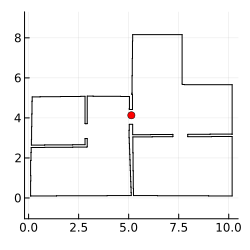

In [2]:
using JLD2
using Plots
using StatsBase: mean
using Geometry: Segment, distance, bounding_box, diff, norm

fname = "data/data.jld2"
d = load_object(fname)
env = d[:env][:segs];

center = mean(bounding_box(env))
# -------------
plot(size=(250,250), aspect_ratio=:equal, legend=false)
plot!(env, c=:black)
scatter!([center], c=:red)

In [138]:
using LinearAlgebra
function segnormal_pdf(x::Vector{Float64}, s::Segment, sig::Float64=1.0)
    if s.y == s.x
        p0 = pdf(Normal(0, sig), 0)
        return p0*pdf(Normal(0, sig), norm(s.x - x))
    end
    v  = s.y - s.x
    iv = [v[2];v[1]]
    w  = abs(dot(iv/norm(iv), s.x - x ))
    v1 = dot( v/norm(v) , s.x - x )
    v2 = dot( v/norm(v) , s.y - x )
    integral = cdf(Normal(0,sig), v2) - cdf(Normal(0,sig), v1)
    pw = pdf(Normal(0,sig), w)
    return 1/norm(v)*pw*integral
end

segnormal_pdf (generic function with 2 methods)

In [4]:
segs = [
    Segment([0;0],[1;0]),
    Segment([1;0],[1;3]),
    Segment([0;0],[0;0]),
    Segment([0;0.5],[0.2;0.5])
]
bb =bounding_box(segs)
Q = Product([Uniform(bb[1][1]-0.5,bb[2][1]+0.5), Uniform(bb[1][2]-0.5,bb[2][2]+0.5)])
xs = [rand(Q) for t=1:3000]
xs[1]

2-element Vector{Float64}:
  1.427829264938525
 -0.05427835422444405

1.2666652505904589e-14
0.5774493668369324


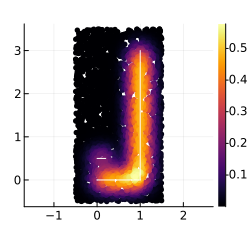

In [5]:
vs = []
sig = 0.2
for x in xs
    ps = [segnormal_pdf(x, s, sig) for s in segs]
    ws = [norm(s) for s in segs]
    ws = ws/sum(ws)
    push!(vs, sum(ws.*ps))
end
println(minimum(vs))
println(maximum(vs))
perm = sortperm(vs)
plot(size=(250,250), aspect_ratio=:equal)
scatter!(xs[perm], zcolor=vs[perm], markerstrokewidth=0, markersize=3, label=nothing)
plot!(segs, c=:white, label=nothing)

In [6]:
segs = env
bb =bounding_box(segs)
Q = Product([Uniform(bb[1][1]-0.5,bb[2][1]+0.5), Uniform(bb[1][2]-0.5,bb[2][2]+0.5)])
xs = [rand(Q) for t=1:5000]
xs[1]

2-element Vector{Float64}:
 10.013219089776829
  0.6388616746895798

0.00023949202099544098
0.03660562107736491


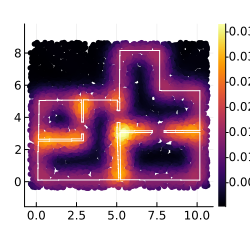

In [7]:
vs = []
sig = 0.5
for x in xs
    ps = [segnormal_pdf(x, s, sig) for s in segs]
    ws = [norm(s) for s in segs]
    ws = ws/sum(ws)
    push!(vs, sum(ws.*ps))
end
println(minimum(vs))
println(maximum(vs))
perm = sortperm(vs)
plot(size=(250,250), aspect_ratio=:equal)
scatter!(xs[perm], zcolor=vs[perm], markerstrokewidth=0, markersize=3, label=nothing)
plot!(segs, c=:white, label=nothing)

# Reality Check

In [145]:
sig = .5
mu  = rand(2)
x   = rand(2)
pdf(MvNormal(mu,[[sig^2 0];[0 sig^2]]), x),
pdf(Normal(mu[1],sig), x[1])*pdf(Normal(mu[2],sig), x[2])

(0.4562193524583029, 0.45621935245830303)

N=10^1	err=-0.005853259874760401 - -0.4384882413377036 - 0.6598083643963246
N=10^2	err=-0.0006079491949758735 - -0.04512786719389528 - 0.07055475750229956
N=10^3	err=-6.104805000575368e-5 - -0.0045346989888672695 - 0.0071055455964428305
N=10^4	err=-6.107361813766768e-6 - -0.0004536912153882966 - 0.000711060195508928


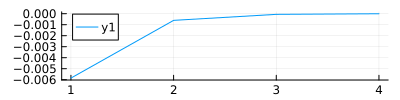

In [146]:
function segnormal_pdf_approx(x::Vector{Float64}, s::Segment, sig::Float64=1.0; N = 10)
    # Mixture of N+1 Gaussians placed on the segment
    v  = s.y - s.x
    ys = [s.x + i/N*v for i=0:N]
    return sum([1/(N+1)*pdf(MvNormal(ys[i+1],[[sig^2 0.0];[0.0 sig^2]]), x) for i=0:N])
end

seg = Segment([0.25;0.5], [0.75;0.5])
sig = .1
xs = [rand(2) for t=1:1_000];

errs = []
for e=1:4
    N = 10^e
    vs = segnormal_pdf.(xs,[seg],[sig]) - segnormal_pdf_approx.(xs,[seg],[sig]; N=N)
    push!(errs, vs)
    println("N=10^$(e)\terr=$(mean(vs)) - $(minimum(vs)) - $(maximum(vs))")
end
plot(mean.(errs), size=(400,100))

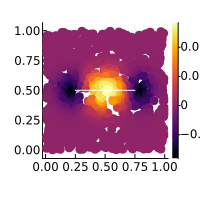

In [147]:
i = 4
perm = sortperm(errs[i])
plot(size=(200,200), aspect_ratio=:equal)
scatter!(xs[perm], zcolor=errs[i][perm], markerstrokewidth=0, markersize=5, label=nothing)
plot!(seg, c=:white, label=nothing)

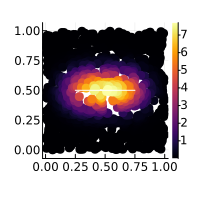

In [148]:
sig = 0.1
vs = segnormal_pdf_approx.(xs,[seg],[sig]; N=50)
perm = sortperm(vs)
plot(size=(200,200), aspect_ratio=:equal)
scatter!(xs[perm], zcolor=vs[perm], markerstrokewidth=0, markersize=5, label=nothing)
plot!(seg, c=:white, label=nothing)

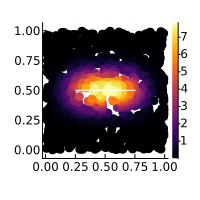

In [149]:
vs = segnormal_pdf.(xs,[seg],[sig])
perm = sortperm(vs)
plot(size=(200,200), aspect_ratio=:equal)
scatter!(xs[perm], zcolor=vs[perm], markerstrokewidth=0, markersize=5, label=nothing)
plot!(seg, c=:white, label=nothing)